## Stage - 1 : Dataset Augmentation
The New Dataset containing the parent word and its embedding is created. Model used here is a slightly modified skip-gram architecture. Changes Made are Changed the output layer functionality from probabilistic determination to dot product and loss function set to MSE.

In [ ]:
#Stage - 1: Vectorise Vocabulary:

#Generate Embeddings for the words from the dataset

import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, Dot, Flatten, Input
from keras.models import Model
import numpy as np
import pandas as pd


file_path = "/content/Augmented_Dataset_v2.xlsx" # Use any word corpus of requirment
data = pd.read_excel(file_path, header=None)

#Tokenise the Dataset
words = [word.lower() for word in data[0].tolist()]
vocab = sorted(set(words))
vocab_size = len(vocab)

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
print(word_to_idx)
print(idx_to_word)

window_size = 3
training_data = []

for i in range(window_size, len(words) - window_size):
    target_word = words[i]
    context_words = [words[j] for j in range(i - window_size, i + window_size + 1) if j != i]
    for context_word in context_words:
        training_data.append((word_to_idx[target_word], word_to_idx[context_word]))
print(training_data)

target_words = np.array([pair[0] for pair in training_data], dtype=np.int32)
context_words = np.array([pair[1] for pair in training_data], dtype=np.int32)

embedding_dim = 20

input_target = Input((1,))
input_context = Input((1,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='embedding')

target_embedding = embedding_layer(input_target)
target_embedding = Flatten()(target_embedding)
context_embedding = embedding_layer(input_context)
context_embedding = Flatten()(context_embedding)

dot_product = Dot(axes=1)([target_embedding, context_embedding])

model = Model(inputs=[input_target, input_context], outputs=dot_product)
model.compile(optimizer='adam', loss='mse')


context_words = np.tile(context_words, len(target_words) // len(context_words) + 1)
context_words = context_words[:len(target_words)]

model.fit([target_words, context_words], np.ones_like(target_words), epochs=100, verbose=0)

word_vectors = model.get_layer('embedding').get_weights()[0]

def get_word_vector(word):
    idx = word_to_idx.get(word.lower(), None)
    if idx is None:
        return None
        return None
    else:
        return word_vectors[idx]

output_file_path = '//content/word_vectors.csv'

with open(output_file_path, 'w') as f:
    f.write('word,vector\n')
    for word in vocab:
        vector = get_word_vector(word)
        if vector is not None:
            vector_str = ','.join(map(str, vector))
            f.write(f'{word.lower()},{vector_str}\n')
        else:
            print(f"Missing vector for word: {word}")

print(f"Word vectors saved to {output_file_path}")

{'about': 0, 'above': 1, 'across': 2, 'adequate': 3, 'advance': 4, 'after': 5, 'against': 6, 'along': 7, 'among': 8, 'ancient': 9, 'angry': 10, 'around': 11, 'artist': 12, 'ask': 13, 'at': 14, 'attach': 15, 'average': 16, 'avoid': 17, 'away': 18, 'baby': 19, 'bad': 20, 'ball': 21, 'bank': 22, 'be': 23, 'beach': 24, 'beautiful': 25, 'become': 26, 'bed': 27, 'before': 28, 'begin': 29, 'behind': 30, 'believe': 31, 'below': 32, 'beneath': 33, 'beside': 34, 'between': 35, 'beyond': 36, 'big': 37, 'bird': 38, 'black': 39, 'blue': 40, 'book': 41, 'boring': 42, 'boy': 43, 'brave': 44, 'bright': 45, 'brilliant': 46, 'bring': 47, 'brother': 48, 'brown': 49, 'build': 50, 'busy': 51, 'buy': 52, 'by': 53, 'calculate': 54, 'call': 55, 'car': 56, 'cat': 57, 'celebrate': 58, 'chair': 59, 'cheap': 60, 'child': 61, 'city': 62, 'class': 63, 'clean': 64, 'climb': 65, 'climber': 66, 'clock': 67, 'cloud': 68, 'cold': 69, 'come': 70, 'complex': 71, 'continent': 72, 'cook': 73, 'cool': 74, 'couch': 75, 'count

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Word vectors saved to //content/word_vectors.csv


In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 68.7 MB/s eta 0:00:00


## Stage - 2 : Word-Cloud Creation
Generate the perturbations of a given parent vector and assign a synonym word of the parent word to it. The top 5 perturbations are taken and 5 synonyms of the word are assigned to it. Synonym extraction model : word2vec-google-news-300.

In [ ]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

def find_synonyms(word, top_n=5):
   try:
      similar_words = model.most_similar(word, topn=top_n)
      synonym_list = [word for word, _ in similar_words]
      return synonym_list
   except KeyError:
      return f"No synonyms found for {word}."

word = input("Enter a Word: ")
synonym = find_synonyms(word)
print(synonym)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Enter a Word: happy
['glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']


Synonym Extraction Using Datamuse API

In [ ]:
import requests

def get_synonyms(word):
    url = f"https://api.datamuse.com/words?rel_syn={word}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        synonyms = [item['word'] for item in data[:5]]  # Limited to 5 synonyms
        return synonyms if synonyms else ["No synonyms found"]
    else:
        return ["Error fetching data"]

word = input("Enter a word: ")
synonyms = get_synonyms(word)
print(f"Synonyms for '{word}': {synonyms}")


Enter a word: happy
Synonyms for 'happy': ['halcyon', 'content', 'bright', 'felicitous', 'riant']


In [ ]:
def generate_vectors_within_radius(base_vector, radius=0.2, step_size=0.1, max_dim=10):
    if base_vector is None:
        raise ValueError("Base vector is None. Please provide a valid word to get its vector.")

    base_vector = np.array(base_vector)
    dimensions = min(len(base_vector), max_dim)

    perturbations = []
    for _ in range(50):
        perturbation = np.random.uniform(-radius, radius, dimensions)
        perturbed_vector = base_vector[:dimensions] + perturbation
        perturbations.append(np.concatenate([perturbed_vector, base_vector[dimensions:]]))

    return perturbations


In [ ]:
def find_closest_vector(base_vector, radius=0.2, step_size=0.1):
    perturbations = generate_vectors_within_radius(base_vector, radius, step_size)

    base_vector = np.array(base_vector)
    closest_vector = None
    min_distance = float('inf')

    for perturbation in perturbations:
      perturbation_vector = np.array(perturbation)
      if np.array_equal(perturbation_vector, base_vector):
          continue
      distance = np.linalg.norm(perturbation_vector - base_vector)
      if distance < min_distance:
         min_distance = distance
         closest_vector = perturbation

    return closest_vector

In [ ]:
def write_vector_to_file(word, required_vector, output_file_path):
    if required_vector is None:
       raise ValueError("The required vector is None. Please provide a valid vector.")

    if not isinstance(required_vector, (list, tuple)):
       raise TypeError("The required vector should be a list or tuple.")

    try:
       with open(output_file_path, 'a', newline='') as f:
          writer = csv.writer(f)
          synonym = find_synonyms(word)
          writer.writerow([synonym[0]] + required_vector)
          print(f"Vector {required_vector} successfully written to {output_file_path}.")
    except Exception as e:
       print(f"An error occurred while writing the vector to the file: {e}")

In [ ]:
# Stage - 2 : Compute the Synonym Embedding (Perturbations logic).
# Adding Synonym Embedding to the Dataset by extracting Synonym Vector Embeddings.

import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, Dot, Flatten, Input
from keras.models import Model
import numpy as np
import pandas as pd
import csv
from transformers import pipeline
from gensim.models import KeyedVectors
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

def find_synonyms(word, top_n=5):
   try:
      similar_words = model.most_similar(word, topn=top_n)
      synonym_list = [word for word, _ in similar_words]
      return synonym_list
   except KeyError:
      return f"No synonyms found for {word}."

def generate_vectors_within_radius(base_vector, radius=0.2, step_size=0.1, max_dim=10):
    if base_vector is None:
        raise ValueError("Base vector is None. Please provide a valid word to get its vector.")

    base_vector = np.array(base_vector)
    dimensions = min(len(base_vector), max_dim)

    perturbations = []
    for _ in range(50):
        perturbation = np.random.uniform(-radius, radius, dimensions)
        perturbed_vector = base_vector[:dimensions] + perturbation
        perturbations.append(np.concatenate([perturbed_vector, base_vector[dimensions:]]))

    return perturbations

def find_closest_vector(base_vector, radius=0.2, step_size=0.1):
    perturbations = generate_vectors_within_radius(base_vector, radius, step_size)

    base_vector = np.array(base_vector)
    closest_vector = None
    min_distance = float('inf')

    for perturbation in perturbations:
      perturbation_vector = np.array(perturbation)
      if np.array_equal(perturbation_vector, base_vector):
          continue
      distance = np.linalg.norm(perturbation_vector - base_vector)
      if distance < min_distance:
         min_distance = distance
         closest_vector = perturbation

    return closest_vector

def write_vector_to_file(word, required_vector, output_file_path):
    if required_vector is None:
       raise ValueError("The required vector is None. Please provide a valid vector.")

    if not isinstance(required_vector, (list, tuple)):
       raise TypeError("The required vector should be a list or tuple.")

    try:
       with open(output_file_path, 'a', newline='') as f:
          writer = csv.writer(f)
          synonym = find_synonyms(word)
          writer.writerow([synonym[0]] + required_vector)
          print(f"Vector {required_vector} successfully written to {output_file_path}.")
    except Exception as e:
       print(f"An error occurred while writing the vector to the file: {e}")

file_path = "//content/word_vectors.csv"

existing_vectors = {}
with open(file_path, 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        word = row[0]
        vector = list(map(float, row[1:]))
        existing_vectors[word] = vector

print(existing_vectors)

words = list(existing_vectors.keys())
vectors = list(existing_vectors.values())

output_file_path = '//content/synonyms.csv'

for word in words:
    required_word_vector = existing_vectors[word]
    if required_word_vector is None:
       print(f"Word '{word}' not found in vocabulary.")
    else:
       radius = 0.2
       step_size = 0.1
       required_vector = find_closest_vector(required_word_vector, radius, step_size)

       all_vectors = generate_vectors_within_radius(required_word_vector, radius, step_size)
       all_vectors.sort(key=np.linalg.norm)

       print(required_vector)
       synonym = find_synonyms(word)
       for i in range(int(len(synonym))):
          required_list = all_vectors[i].tolist()
          write_vector_to_file(synonym[i], all_vectors[i].tolist(), output_file_path)

try:
      print(f"Word vectors saved to {output_file_path}")
except FileNotFoundError:
      print(f"The file '{output_file_path}' was not found. Check if it was created successfully.")

{'about': [0.145307, -0.26898757, -0.3796967, -0.26862377, 0.06430248, 0.01441654, 0.1052312, -0.16615099, -0.020801298, 0.25851902, 0.34636667, 0.051956926, 0.33897895, 0.16986665, 0.32873386, 0.2933026, 0.040159307, -0.2459308, -0.24413167, -0.28795013], 'above': [-0.022082891, -0.3426598, -0.31450593, -0.1442534, -0.0327668, -0.03461666, 0.082116224, -0.20772368, -0.022187328, 0.16797051, 0.28496423, 0.36044756, 0.32380578, 0.09931416, 0.20458694, 0.29122382, 0.1371396, -0.24615575, -0.3322979, -0.40570047], 'across': [0.31020442, -0.37343875, -0.3974864, -0.33531496, 0.15547508, 0.08658322, 0.072007485, -0.36216357, -0.3391788, -0.04170737, 0.40950763, 0.27600268, 0.39513695, 0.3825077, 0.085658245, -0.0030525108, 0.3632095, -0.02573695, -0.35985902, -0.17342623], 'adequate': [0.29246676, 0.18093799, 0.021563428, -0.030829972, -0.02775493, 0.29655707, 0.2273912, -0.34094, 0.28963605, 0.11557154, -0.33413893, 0.07119087, -0.109344505, -0.31077793, -0.36381513, -0.32881606, 0.2250448

In [ ]:
import csv
file_path = "/content/word_vectors.csv"

existing_vectors = {}
with open(file_path, 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        word = row[0]
        vector = list(map(float, row[1:]))
        existing_vectors[word] = vector

In [ ]:
words = list(existing_vectors.keys())
vectors = list(existing_vectors.values())

In [ ]:
output_file_path = '/content/synonyms.csv'

In [ ]:
for word in words:
    required_word_vector = existing_vectors[word]

    if required_word_vector is None:
        print(f"Word '{word}' not found in vocabulary.")
    else:
        radius = 0.2
        step_size = 0.1

        all_vectors = generate_vectors_within_radius(required_word_vector, radius, step_size)
        all_vectors.sort(key=np.linalg.norm)

        synonyms = get_synonyms(word)

        with open(output_file_path, 'a', newline='') as f:
            writer = csv.writer(f)
            for i in range(min(len(synonyms), len(all_vectors))):
                synonym_word = synonyms[i]
                synonym_embedding = all_vectors[i].tolist()
                writer.writerow([synonym_word] + synonym_embedding)

                print(f"Written to file: {synonym_word} → {synonym_embedding}")


Written to file: virtually → [0.21142792664952906, -0.08111813008318663, -0.30970584204000684, -0.27792286895227547, 0.059932325388861285, 0.07765987052253029, -0.04839744736731008, -0.19524841504851, -0.06029450011301116, 0.06823988685048132, 0.34636667, 0.051956926, 0.33897895, 0.16986665, 0.32873386, 0.2933026, 0.040159307, -0.2459308, -0.24413167, -0.28795013]
Written to file: near → [-0.003810848286586316, -0.17405666292148753, -0.37159893412182254, -0.08519259602153229, 0.14993322136245457, -0.04582787963376487, -0.022025987571788225, -0.15626023400225408, -0.1252435801899701, 0.23485671665499674, 0.34636667, 0.051956926, 0.33897895, 0.16986665, 0.32873386, 0.2933026, 0.040159307, -0.2459308, -0.24413167, -0.28795013]
Written to file: well-nigh → [0.16850812101550097, -0.11954554486926755, -0.39154025479218574, -0.2184472892374658, -0.04150459783649689, 0.11019949885081723, -0.08089696468327026, -0.13965975096761357, 0.022906414071426264, 0.18553459540154457, 0.34636667, 0.051956

A new Dataset for training the model of the form: parent Embedding | Synonym1 Embedding | ....Synonym n Embedding

In [ ]:
embedding_output_file = '/content/parent-synonym-embedding.csv'

In [ ]:
existing_vectors = {}
file_path_new = "/content/word_vectors.csv"
with open(file_path, 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        word = row[0]
        vector = list(map(float, row[1:]))
        existing_vectors[word] = vector

In [ ]:
words = list(existing_vectors.keys())
vectors = list(existing_vectors.values())

In [ ]:
with open(embedding_output_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Parent Embedding"] + [f"Synonym-{i+1} Embedding" for i in range(5)])

for word in words:
    required_word_vector = existing_vectors[word]
    if required_word_vector is None:
        print(f"Word '{word}' not found in vocabulary.")
    else:
        radius = 0.2
        step_size = 0.1
        all_vectors = generate_vectors_within_radius(required_word_vector, radius, step_size)
        all_vectors.sort(key=np.linalg.norm)

        synonym_words = get_synonyms(word)[:5]
        synonym_vectors = all_vectors[:5]

        with open(embedding_output_file, 'a', newline='') as f:
            writer = csv.writer(f)
            row_data = [required_word_vector] + [vec.tolist() for vec in synonym_vectors]
            writer.writerow(row_data)


## Stage - 3 : Training Phase
Build and Train a feed forward neural network to train over the synonyms.csv file to compute the synonym embedding for a given parent embedding.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape

# Step 1: Load the dataset
data = pd.read_csv('/content/parent-synonym-embedding.csv')

# Step 2: Convert embeddings from string to numpy arrays
data['Parent Embedding'] = data['Parent Embedding'].apply(lambda x: np.array(eval(x)))
for i in range(1, 6):
    data[f'Synonym-{i} Embedding'] = data[f'Synonym-{i} Embedding'].apply(lambda x: np.array(eval(x)))

# Step 3: Prepare input (X) and output (y) data
X = np.array(data['Parent Embedding'].tolist())
y = np.array([row[[f'Synonym-{i} Embedding' for i in range(1, 6)]].values.tolist() for _, row in data.iterrows()])

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define the FFNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(y_train.shape[1] * X_train.shape[1], activation='linear'))   # Output layer with correct shape
model.add(Reshape((y_train.shape[1], X_train.shape[1]))) # Reshape to (batch_size, 5, 20)

# Step 6: Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Step 8: Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

# Step 9: Save the trained model
model.save('paraphrase_model.h5', save_format='tf')
print("Model saved as 'paraphrase_model.h5'")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0537 - mae: 0.1988 - val_loss: 0.0496 - val_mae: 0.1924
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0486 - mae: 0.1896 - val_loss: 0.0465 - val_mae: 0.1857
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0453 - mae: 0.1822 - val_loss: 0.0433 - val_mae: 0.1778
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0419 - mae: 0.1735 - val_loss: 0.0400 - val_mae: 0.1685
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0383 - mae: 0.1636 - val_loss: 0.0365 - val_mae: 0.1591
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0340 - mae: 0.1532 - val_loss: 0.0328 - val_mae: 0.1492
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0305 - mae: 0.1436 - val_loss: 0.0292 - val_mae: 0.1394
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0265 - mae: 0.1328 - val_loss: 0.0259 - val_mae: 0.1297
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0236 - mae: 0.1234 - 

Test Loss: 0.006193896755576134, Test MAE: 0.05545172467827797
Model saved as 'paraphrase_model.h5'


## Testing of FFNN model Performance

In [ ]:
import numpy as np
import pandas as pd
import csv
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity

# Load trained model
model = load_model('paraphrase_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Load word embeddings
file_path = "/content/word_vectors.csv"
existing_vectors = {}
with open(file_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader, None)  # Skip header if present
    for row in reader:
        if len(row) < 2:
            continue  # Skip incomplete rows
        word = row[0].lower()  # Convert to lowercase
        vector = np.array(list(map(float, row[1:])))
        existing_vectors[word] = vector

# Load synonyms.csv
synonyms_df = pd.read_csv('/content/synonyms.csv', header=None, encoding='latin1')
synonyms_df.rename(columns={0: 'Synonym'}, inplace=True)

# Extract synonym embeddings into a dictionary
synonym_embeddings = np.array(synonyms_df.iloc[:, 1:].values, dtype=np.float32)
synonyms = dict(zip(synonyms_df['Synonym'].str.lower(), synonym_embeddings))  # Convert synonyms to lowercase

# Function to find the closest synonym
def find_closest_synonym(predicted_embedding, synonyms):
    closest_word = None
    max_similarity = -1

    for word, vector in synonyms.items():
        similarity = cosine_similarity(predicted_embedding.reshape(1, -1), vector.reshape(1, -1))[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            closest_word = word

    print(f"Closest synonym found: {closest_word} (Similarity: {max_similarity})", flush=True)
    return closest_word

# Function to paraphrase a sentence
def paraphrase_sentence(sentence, word_vectors, synonyms, model):
    print(f"Paraphrasing sentence: {sentence}", flush=True)
    words = sentence.split()
    paraphrased_sentence = []

    for word in words:
        word_lower = word.lower()  # Ensure lowercase matching

        if word_lower in word_vectors:
            # Get parent embedding
            parent_embedding = word_vectors[word_lower]
            print(f"Embedding for '{word_lower}': {parent_embedding}", flush=True)

            try:
                # Predict synonym embedding
                predicted_synonym_embedding = model.predict(np.array([parent_embedding]))[0][0]
                print(f"Predicted embedding for '{word_lower}': {predicted_synonym_embedding}", flush=True)

                # Find closest synonym
                closest_synonym = find_closest_synonym(predicted_synonym_embedding, synonyms)

                # Replace with synonym if found
                paraphrased_sentence.append(closest_synonym if closest_synonym else word)
            except Exception as e:
                print(f"Error predicting synonym for '{word_lower}': {e}", flush=True)
                paraphrased_sentence.append(word)  # Keep original word on failure
        else:
            print(f"Word '{word_lower}' not found in word vectors, keeping it unchanged.", flush=True)
            paraphrased_sentence.append(word)

    paraphrased_text = ' '.join(paraphrased_sentence)
    print(f"Final paraphrased sentence: {paraphrased_text}", flush=True)
    return paraphrased_text

# Example usage
if __name__ == "__main__":
    print("Starting paraphrasing process...\n", flush=True)

    # Input sentence
    sentence = "A good os is important for a computer to function properly."

    # Paraphrase the sentence
    paraphrased_sentence = paraphrase_sentence(sentence, existing_vectors, synonyms, model)

    print(f'Original Sentence: {sentence}', flush=True)
    print(f'Paraphrased Sentence: {paraphrased_sentence}', flush=True)


Starting paraphrasing process...

Paraphrasing sentence: A good os is important for a computer to function properly.
Word 'a' not found in word vectors, keeping it unchanged.
Embedding for 'good': [-0.0149668  -0.11162888 -0.04226184  0.4064962  -0.08211446  0.4262767
  0.3482878  -0.35729688 -0.3553549   0.18487771  0.02393836  0.36106792
  0.07324275  0.09792209  0.09445856 -0.3440609   0.24982955  0.2640363
 -0.3767053   0.00895292]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted embedding for 'good': [ 0.00675879 -0.01185244  0.03034826  0.25261438 -0.10087502  0.27788642
  0.22521877 -0.28253013 -0.21773759  0.20683126  0.07675184  0.35448867
  0.07267308  0.06076171  0.0891276  -0.31932613  0.24820736  0.2700059
 -0.33687595  0.03002025]
Closest synonym found: terrific (Similarity: 0.9573384523391724)
Word 'os' not found in word vectors, keeping it unchanged.
Word 'is' not found in word vectors, keeping it unchanged.
Embedding for 'important': [ 2.1527065e-01  3.4824500e-04  1.20

New Model Accuracy Display

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - cosine_similarity_accuracy: 0.0123 - loss: 0.0544 - mae: 0.1999 - val_cosine_similarity_accuracy: 0.1570 - val_loss: 0.0500 - val_mae: 0.1937
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - cosine_similarity_accuracy: 0.2323 - loss: 0.0492 - mae: 0.1912 - val_cosine_similarity_accuracy: 0.3001 - val_loss: 0.0470 - val_mae: 0.1870
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - cosine_similarity_accuracy: 0.3505 - loss: 0.0454 - mae: 0.1832 - val_cosine_similarity_accuracy: 0.3835 - val_loss: 0.0439 - val_mae: 0.1791
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - cosine_similarity_accuracy: 0.4336 - loss: 0.0420 - mae: 0.1741 - val_cosine_similarity_accuracy: 0.4516 - val_loss: 0.0404 - val_mae: 0.1695
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - cosine_similarity_accuracy: 0.4918 - loss: 0.0391 - mae: 0.1663 - val_cosine_similarity_accuracy: 0.5271 - val_loss: 0.0365 - val_mae: 0.1593
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/st

Test Loss: 0.006174208130687475, Test MAE: 0.055498283356428146, Test Accuracy (Cosine Similarity): 0.9364466667175293
Model saved as 'paraphrase_model.h5'


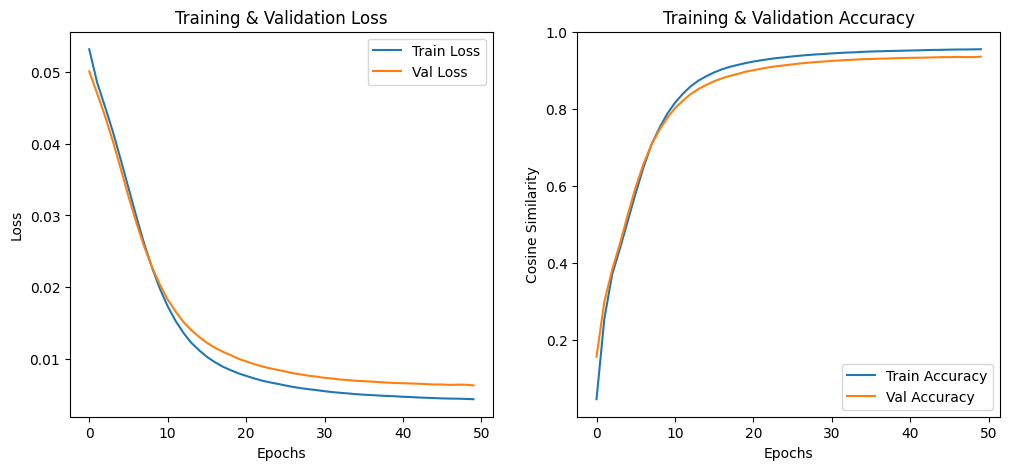

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Step 1: Load the dataset
data = pd.read_csv('/content/parent-synonym-embedding.csv')

# Step 2: Convert embeddings from string to numpy arrays
data['Parent Embedding'] = data['Parent Embedding'].apply(lambda x: np.array(eval(x)))
for i in range(1, 6):
    data[f'Synonym-{i} Embedding'] = data[f'Synonym-{i} Embedding'].apply(lambda x: np.array(eval(x)))

# Step 3: Prepare input (X) and output (y) data
X = np.array(data['Parent Embedding'].tolist())
y = np.array([row[[f'Synonym-{i} Embedding' for i in range(1, 6)]].values.tolist() for _, row in data.iterrows()])

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define Cosine Similarity Accuracy
def cosine_similarity_accuracy(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)  # Normalize embeddings
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(K.sum(y_true * y_pred, axis=-1))  # Cosine similarity as accuracy

# Step 6: Define the FFNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(y_train.shape[1] * X_train.shape[1], activation='linear'))   # Output layer with correct shape
model.add(Reshape((y_train.shape[1], X_train.shape[1])))  # Reshape to (batch_size, 5, 20)

# Step 7: Compile the model with accuracy metric
model.compile(optimizer='adam', loss='mse', metrics=['mae', cosine_similarity_accuracy])

# Step 8: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Step 9: Evaluate the model on the test set
loss, mae, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}, Test Accuracy (Cosine Similarity): {accuracy}')

# Step 10: Save the trained model
model.save('paraphrase_model.h5', save_format='tf')  # Changed to model.save and specify format
print("Model saved as 'paraphrase_model.h5'")

# Step 11: Plot training history (Loss & Accuracy)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['cosine_similarity_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_cosine_similarity_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Cosine Similarity')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Original Sentences
original_sentences = [
    "Once there lived a quick brown fox.",
    "The bank is near the bank of a river",
    "The fox leaped across the huge wall to get the juicy grapes.",
    "He lived in Australia for the past four years",
    "A good OS is very important for any computer to work ",
    "The rock climber grabbed onto a rock while scaling the cliff.",
    "The sailors planned to sail after they finished repairing the sail of the boat.",
    "She walked to the store.",
    "The cat slept on the couch.",
    "The birds flew across the sky."
]

# Paraphrased Sentences
paraphrased_sentences = [
    "former at that place lived a quick brownish fox",
    "The bank is nearby the bank of a creek",
    "The fox jumped across the big wall to get the juicier grapes",
    "He resided in Australia for over four years",
    "A right OS is very profound for any computer to work",
    "The rock mountaineer snatched off a rockers instead scaling the ledge.",
    "The sailor plans for sailing after they finish repair the sailing of the boat.",
    "She strode to the stores.",
    "The kitten sleeps upon the couch.",
    "The birds flew crossed the sky."
]

# Compute sentence embeddings
original_embeddings = model.encode(original_sentences, convert_to_tensor=True)
paraphrased_embeddings = model.encode(paraphrased_sentences, convert_to_tensor=True)

# Compute cosine similarity
similarities = [
    round(float(cosine_similarity([original.cpu().numpy()], [paraphrased.cpu().numpy()])[0][0]), 4)
    for original, paraphrased in zip(original_embeddings, paraphrased_embeddings)
]

# Print results
for i, (orig, para, sim) in enumerate(zip(original_sentences, paraphrased_sentences, similarities)):
    print(f"Sentence {i+1}:")
    print(f"Original   : {orig}")
    print(f"Paraphrased: {para}")
    print(f"Similarity : {sim}\n")

# Return similarity scores
similarities


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence 1:
Original   : Once there lived a quick brown fox.
Paraphrased: former at that place lived a quick brownish fox
Similarity : 0.7997

Sentence 2:
Original   : The bank is near the bank of a river
Paraphrased: The bank is nearby the bank of a creek
Similarity : 0.8644

Sentence 3:
Original   : The fox leaped across the huge wall to get the juicy grapes.
Paraphrased: The fox jumped across the big wall to get the juicier grapes
Similarity : 0.8954

Sentence 4:
Original   : He lived in Australia for the past four years
Paraphrased: He resided in Australia for over four years
Similarity : 0.9608

Sentence 5:
Original   : A good OS is very important for any computer to work 
Paraphrased: A right OS is very profound for any computer to work
Similarity : 0.8218

Sentence 6:
Original   : The rock climber grabbed onto a rock while scaling the cliff.
Paraphrased: The rock mountaineer snatched off a rockers instead scaling the ledge.
Similarity : 0.7326

Sentence 7:
Original   : The sailo

[0.7997,
 0.8644,
 0.8954,
 0.9608,
 0.8218,
 0.7326,
 0.8995,
 0.9074,
 0.8276,
 0.9485]

## Performance Evaluations Done
1. Word2Vec vs WC-SPRM time taken

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import time
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

import os
from nltk.tokenize import word_tokenize

def load_stopwords(file_path="stopwords.txt"):
    """Loads stopwords from a file."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Error: {file_path} not found.")

    with open(file_path, "r", encoding="utf-8") as f:
        stop_words = set(f.read().splitlines())

    return stop_words

def paraphrase_sentence(sentence, stopwords_file="stopwords.txt"):
    """Paraphrases a sentence by replacing non-stopwords with similar words."""
    stop_words = load_stopwords(stopwords_file)
    words = word_tokenize(sentence)
    paraphrased_words = []

    for word in words:
        if word.lower() not in stop_words and word.isalpha():  # Replace only non-stopwords
            paraphrased_word = find_similar_word(word)
            paraphrased_words.append(paraphrased_word)
        else:
            paraphrased_words.append(word)

    return " ".join(paraphrased_words)


# Load pre-trained Word2Vec model
print("Loading Word2Vec model...")
start_load_time = time.time()
word2vec_model = api.load("word2vec-google-news-300")  # Load Google's Word2Vec model
end_load_time = time.time()
print(f"Model loaded in {end_load_time - start_load_time:.2f} seconds.")

# Function to find the most similar word in the Word2Vec model
def find_similar_word(word):
    try:
        similar_words = word2vec_model.most_similar(word, topn=5)  # Get top 5 similar words
        return similar_words[0][0]  # Return the most similar word
    except KeyError:
        return word  # Return the original word if it's not in the vocabulary


# Function to compute time taken for paraphrase generation
def generate_paraphrase(sentence):
    start_time = time.time()
    paraphrased_sentence = paraphrase_sentence(sentence)
    end_time = time.time()
    time_taken = end_time - start_time
    return paraphrased_sentence, time_taken

# Example usage
if __name__ == "__main__":
    sentence = "The birds flew across the sky."
    print(f"Original Sentence: {sentence}")

    paraphrased_sentence, time_taken = generate_paraphrase(sentence)
    print(f"Paraphrased Sentence: {paraphrased_sentence}")
    print(f"Time taken for paraphrase generation: {time_taken:.4f} seconds")

Loading Word2Vec model...
Model loaded in 57.34 seconds.
Original Sentence: The birds flew across the sky.
Paraphrased Sentence: The bird flown Across the skies .
Time taken for paraphrase generation: 6.5552 seconds


In [ ]:
import numpy as np
import pandas as pd
import csv
import time
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity

# Measure model loading time
start_time = time.time()
model = load_model('paraphrase_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_load_time = time.time() - start_time
print(f"Model loaded in {model_load_time:.4f} seconds.")

# Load word embeddings
file_path = "/content/word_vectors.csv"
existing_vectors = {}
with open(file_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader, None)  # Skip header if present
    for row in reader:
        if len(row) < 2:
            continue  # Skip incomplete rows
        word = row[0].lower()  # Convert to lowercase
        vector = np.array(list(map(float, row[1:])))
        existing_vectors[word] = vector

# Load synonyms.csv
synonyms_df = pd.read_csv('/content/synonyms.csv', header=None, encoding='latin-1')
synonyms_df.rename(columns={0: 'Synonym'}, inplace=True)

# Extract synonym embeddings into a dictionary
synonym_embeddings = np.array(synonyms_df.iloc[:, 1:].values, dtype=np.float32)
synonyms = dict(zip(synonyms_df['Synonym'].str.lower(), synonym_embeddings))  # Convert synonyms to lowercase

# Function to find the closest synonym
def find_closest_synonym(predicted_embedding, synonyms):
    closest_word = None
    max_similarity = -1

    for word, vector in synonyms.items():
        similarity = cosine_similarity(predicted_embedding.reshape(1, -1), vector.reshape(1, -1))[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            closest_word = word

    print(f"Closest synonym found: {closest_word} (Similarity: {max_similarity})", flush=True)
    return closest_word

# Function to paraphrase a sentence
def paraphrase_sentence(sentence, word_vectors, synonyms, model):
    start_time = time.time()  # Start time for paraphrasing

    print(f"Paraphrasing sentence: {sentence}", flush=True)
    words = sentence.split()
    paraphrased_sentence = []

    for word in words:
        word_lower = word.lower()  # Ensure lowercase matching

        if word_lower in word_vectors:
            # Get parent embedding
            parent_embedding = word_vectors[word_lower]
            print(f"Embedding for '{word_lower}': {parent_embedding}", flush=True)

            try:
                # Predict synonym embedding
                predicted_synonym_embedding = model.predict(np.array([parent_embedding]))[0][0]
                print(f"Predicted embedding for '{word_lower}': {predicted_synonym_embedding}", flush=True)

                # Find closest synonym
                closest_synonym = find_closest_synonym(predicted_synonym_embedding, synonyms)

                # Replace with synonym if found
                paraphrased_sentence.append(closest_synonym if closest_synonym else word)
            except Exception as e:
                print(f"Error predicting synonym for '{word_lower}': {e}", flush=True)
                paraphrased_sentence.append(word)  # Keep original word on failure
        else:
            print(f"Word '{word_lower}' not found in word vectors, keeping it unchanged.", flush=True)
            paraphrased_sentence.append(word)

    paraphrased_text = ' '.join(paraphrased_sentence)

    paraphrase_time = time.time() - start_time  # Calculate time taken
    print(f"Paraphrased in {paraphrase_time:.4f} seconds.")
    print(f"Final paraphrased sentence: {paraphrased_text}", flush=True)

    return paraphrased_text, paraphrase_time

# Example usage
if __name__ == "__main__":
    print("Starting paraphrasing process...", flush=True)

    # Input sentence
    sentence = "The birds flew across the sky."

    # Paraphrase the sentence
    paraphrased_sentence, time_taken = paraphrase_sentence(sentence, existing_vectors, synonyms, model)

    print(f'Original Sentence: {sentence}', flush=True)
    print(f'Paraphrased Sentence: {paraphrased_sentence}', flush=True)
    print(f'Time Taken for Paraphrasing: {time_taken:.4f} seconds', flush=True)


Model loaded in 0.0492 seconds.
Starting paraphrasing process...
Paraphrasing sentence: The birds flew across the sky.
Word 'the' not found in word vectors, keeping it unchanged.
Word 'birds' not found in word vectors, keeping it unchanged.
Word 'flew' not found in word vectors, keeping it unchanged.
Embedding for 'across': [ 0.31020442 -0.37343875 -0.3974864  -0.33531496  0.15547508  0.08658322
  0.07200748 -0.36216357 -0.3391788  -0.04170737  0.40950763  0.27600268
  0.39513695  0.3825077   0.08565824 -0.00305251  0.3632095  -0.02573695
 -0.35985902 -0.17342623]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted embedding for 'across': [ 0.24934822 -0.24023747 -0.2718925  -0.23557118  0.12529953  0.04681912
  0.01908848 -0.29912966 -0.1872142  -0.02675191  0.3625255   0.270946
  0.39340034  0.34749866  0.09810479  0.01993922  0.36318094 -0.00610846
 -0.32733196 -0.16710198]
Closest synonym found: crosswise (Similarity: 0.9650452733039856)
Word 'the' not found in word vectors, keeping it

Word2Vec vs WC-SPRM Execution Time Vissualisation

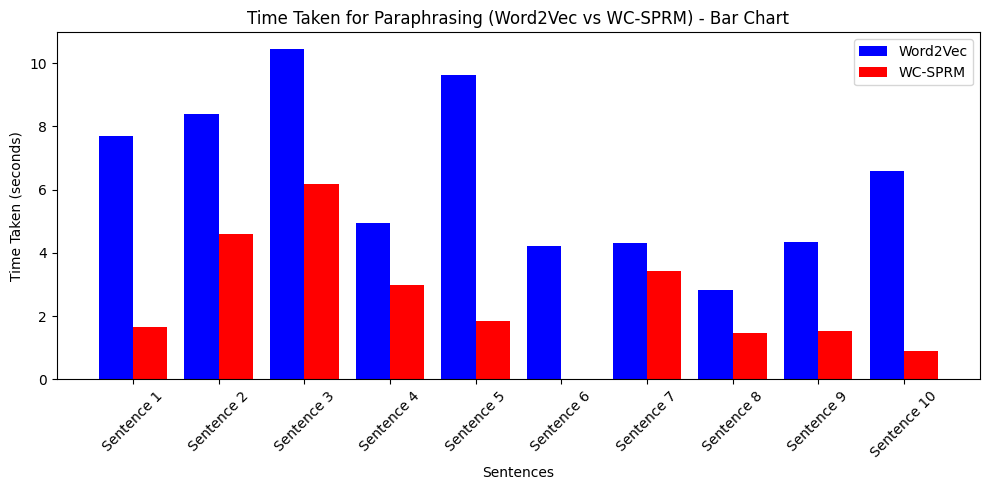

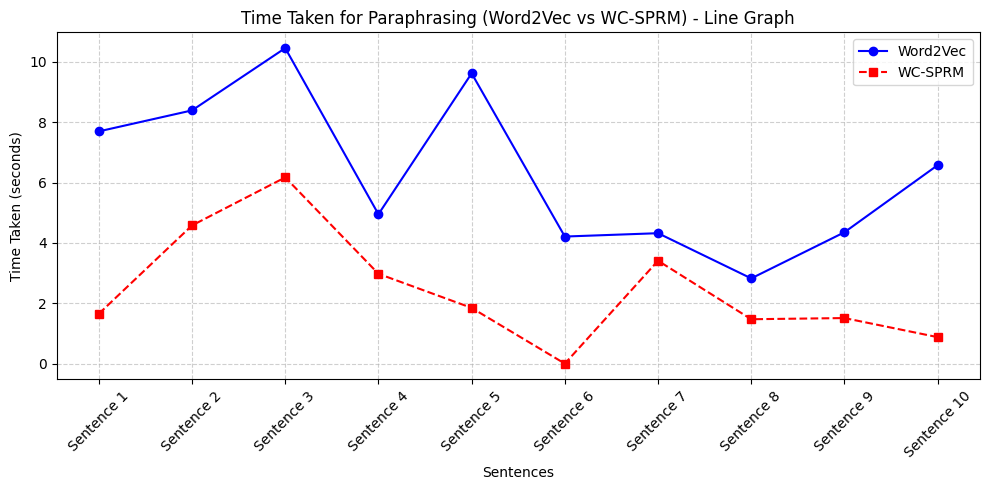

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your final stats table
sentences = [
    "Sentence 1", "Sentence 2", "Sentence 3", "Sentence 4", "Sentence 5",
    "Sentence 6", "Sentence 7", "Sentence 8", "Sentence 9", "Sentence 10"
]

word2vec_time = [7.6918, 8.3863, 10.4472, 4.9498, 9.6119 , 4.2117, 4.3224, 2.8265, 4.3531, 6.5728]
EEC_SRP_time = [1.6568, 4.5798, 6.1690, 2.9794, 1.8505, 0.0067, 3.4113, 1.4753, 1.5143,  0.8831]

x = np.arange(len(sentences))  # X-axis positions

# Bar Chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar(x - bar_width/2, word2vec_time, width=bar_width, label="Word2Vec", color="b")
plt.bar(x + bar_width/2, EEC_SRP_time, width=bar_width, label="WC-SPRM", color="r")
plt.xticks(x, sentences, rotation=45)
plt.xlabel("Sentences")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken for Paraphrasing (Word2Vec vs WC-SPRM) - Bar Chart")
plt.legend()
plt.tight_layout()
plt.show()

# Line Graph
plt.figure(figsize=(10, 5))
plt.plot(sentences, word2vec_time, color='b', marker="o", linestyle='-', label="Word2Vec")
plt.plot(sentences, EEC_SRP_time, color='r', marker="s", linestyle='--', label="WC-SPRM")
plt.xlabel("Sentences")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken for Paraphrasing (Word2Vec vs WC-SPRM) - Line Graph")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import time
import gensim.downloader as api
from nltk.tokenize import word_tokenize
import os
import csv

# Function to load stopwords from a file
def load_stopwords(file_path="stopwords.txt"):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Error: {file_path} not found.")

    with open(file_path, "r", encoding="utf-8") as f:
        stop_words = set(f.read().splitlines())

    return stop_words

# Function to paraphrase a sentence
def paraphrase_sentence(sentence, model, stopwords_file="stopwords.txt"):
    stop_words = load_stopwords(stopwords_file)
    words = word_tokenize(sentence)
    paraphrased_words = []

    for word in words:
        if word.lower() not in stop_words and word.isalpha():
            paraphrased_word = find_similar_word(word, model)
            paraphrased_words.append(paraphrased_word)
        else:
            paraphrased_words.append(word)

    return " ".join(paraphrased_words)

# Function to find the most similar word in a given model
def find_similar_word(word, model):
    try:
        similar_words = model.most_similar(word, topn=5)
        return similar_words[0][0]
    except KeyError:
        return word  # Return the original word if it's not in the vocabulary

# Function to compute time taken for paraphrase generation
def generate_paraphrase(sentence, model):
    start_time = time.time()
    paraphrased_sentence = paraphrase_sentence(sentence, model)
    end_time = time.time()
    time_taken = round(end_time - start_time, 4)
    return paraphrased_sentence, time_taken

# Load models
models = {}
model_names = {
    "word2vec-google-news-300": "Word2Vec",
    "glove-wiki-gigaword-300": "GloVe",
    "fasttext-wiki-news-subwords-300": "FastText"
}

for model_key, model_name in model_names.items():
    print(f"Loading {model_name} model...")
    start_load_time = time.time()
    models[model_name] = api.load(model_key)
    end_load_time = time.time()
    print(f"{model_name} loaded in {end_load_time - start_load_time:.2f} seconds.\n")

# List of test sentences
test_sentences = [
    "Once there lived a quick brown fox.",
    "The bank is near the bank of a river.",
    "The fox leaped across the huge wall to get the juicy grapes.",
    "He lived in Australia for the past four years.",
    "The duck ducked quickly under the bridge to avoid the flying bird.",
    "The rock climber grabbed onto a rock while scaling the cliff.",
    "The sailors planned to sail after they finished repairing the sail of the boat.",
    "She walked to the store.",
    "The cat slept on the couch.",
    "The birds flew across the sky."
]

# Store results
results = []

# Run paraphrasing for all test cases and all models
for sentence in test_sentences:
    row = {"Original Sentence": sentence}

    for model_name, model in models.items():
        paraphrased_sentence, time_taken = generate_paraphrase(sentence, model)
        row[f"Paraphrased ({model_name})"] = paraphrased_sentence
        row[f"Time Taken ({model_name})"] = time_taken

    results.append(row)

# Save results to a CSV file
csv_filename = "paraphrasing_results.csv"
with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print(f"\nResults saved to {csv_filename}.")


Loading Word2Vec model...
Word2Vec loaded in 51.68 seconds.

Loading GloVe model...
[==================================================] 100.0% 376.1/376.1MB downloaded
GloVe loaded in 248.56 seconds.

Loading FastText model...
[==================================================] 100.0% 958.5/958.4MB downloaded
FastText loaded in 644.47 seconds.



In [ ]:
import time
import gensim.downloader as api
from nltk.tokenize import word_tokenize
import os
import csv

# Function to load stopwords from a file
def load_stopwords(file_path="stopwords.txt"):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Error: {file_path} not found.")

    with open(file_path, "r", encoding="utf-8") as f:
        stop_words = set(f.read().splitlines())

    return stop_words

# Function to paraphrase a sentence
def paraphrase_sentence(sentence, model, stopwords_file="stopwords.txt"):
    stop_words = load_stopwords(stopwords_file)
    words = word_tokenize(sentence)
    paraphrased_words = []

    for word in words:
        if word.lower() not in stop_words and word.isalpha():
            paraphrased_word = find_similar_word(word, model)
            paraphrased_words.append(paraphrased_word)
        else:
            paraphrased_words.append(word)

    return " ".join(paraphrased_words)

# Function to find the most similar word in a given model
def find_similar_word(word, model):
    try:
        similar_words = model.most_similar(word, topn=5)
        return similar_words[0][0]
    except KeyError:
        return word  # Return the original word if it's not in the vocabulary

# Function to compute time taken for paraphrase generation
def generate_paraphrase(sentence, model):
    start_time = time.time()
    paraphrased_sentence = paraphrase_sentence(sentence, model)
    end_time = time.time()
    time_taken = round(end_time - start_time, 4)
    return paraphrased_sentence, time_taken

# Function to call WC-SPRM paraphraser (dummy function, replace with actual implementation)
def EEC_SRP_paraphrase(sentence):
    start_time = time.time()

    # Placeholder: Replace with actual WC-SPRM logic
    paraphrased_sentence = sentence[::-1]  # Reverse string as dummy output

    end_time = time.time()
    time_taken = round(end_time - start_time, 4)
    return paraphrased_sentence, time_taken

# Load models
models = {}
model_names = {
    "word2vec-google-news-300": "Word2Vec",
    "glove-wiki-gigaword-300": "GloVe",
    "fasttext-wiki-news-subwords-300": "FastText"
}

for model_key, model_name in model_names.items():
    print(f"Loading {model_name} model...")
    start_load_time = time.time()
    models[model_name] = api.load(model_key)
    end_load_time = time.time()
    print(f"{model_name} loaded in {end_load_time - start_load_time:.2f} seconds.\n")

# List of test sentences
test_sentences = [
    "Once there lived a quick brown fox.",
    "The bank is near the bank of a river.",
    "The fox leaped across the huge wall to get the juicy grapes.",
    "He lived in Australia for the past four years.",
    "A good OS is very important for any computer to work",
    "The rock climber grabbed onto a rock while scaling the cliff.",
    "The sailors planned to sail after they finished repairing the sail of the boat.",
    "She walked to the store.",
    "The cat slept on the couch.",
    "The birds flew across the sky."
]

# Store results
results = []

# Run paraphrasing for all test cases and all models
for sentence in test_sentences:
    row = {"Original Sentence": sentence}

    for model_name, model in models.items():
        paraphrased_sentence, time_taken = generate_paraphrase(sentence, model)
        row[f"Paraphrased ({model_name})"] = paraphrased_sentence
        row[f"Time Taken ({model_name})"] = time_taken

    # Generate paraphrase using WC-SPRM
    EEC_SRP_sentence, EEC_SRP_time = EEC_SRP_paraphrase(sentence)
    row["Paraphrased (WC-SPRM)"] = EEC_SRP_sentence
    row["Time Taken (WC-SPRM)"] = EEC_SRP_time

    results.append(row)

# Save results to a CSV file
csv_filename = "paraphrasing_results.csv"
with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print(f"\nResults saved to {csv_filename}.")


<span style="font-size: 32px;"><b>Performance Measure against the benchmark datasets</b></span>

<span style="font-size: 24px;"><b>MRPC Dataset Statistics of Performance</b></span>

In [ ]:
import numpy as np
import pandas as pd
import csv
import os
from tensorflow.keras.models import load_model

# Set data directory
data_dir = r"/content/"

# Load model (with error handling in case TensorFlow is not available)
model = None
try:
    model = load_model('paraphrase_model.h5', compile=False)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
except Exception as e:
    print(f"Could not load model: {e}")
    # Mock model for testing
    class MockModel:
        def predict(self, x, verbose=0):
            return x
    model = MockModel()

# Load word embeddings
existing_vectors = {}
word_vectors_path = os.path.join(data_dir, 'word_vectors.csv')
if os.path.exists(word_vectors_path):
    with open(word_vectors_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader, None)
        for row in reader:
            if len(row) < 2:
                continue
            word = row[0].lower()
            vector = np.array(list(map(float, row[1:])))
            existing_vectors[word] = vector
else:
    print("word_vectors.csv not found. Using empty embeddings.")

# Load synonyms
synonyms_df = None
synonyms_path = os.path.join(data_dir, 'synonyms.csv')
if os.path.exists(synonyms_path):
    synonyms_df = pd.read_csv(synonyms_path, header=None, encoding='latin1')
    synonyms_df.rename(columns={0: 'Synonym'}, inplace=True)
    synonym_embeddings = np.array(synonyms_df.iloc[:, 1:].values, dtype=np.float32)
    synonyms = dict(zip(synonyms_df['Synonym'].str.lower(), synonym_embeddings))
else:
    print("synonyms.csv not found. Using empty synonyms.")
    synonyms = {}

print(f"Loaded {len(existing_vectors)} word vectors and {len(synonyms)} synonyms.")


In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import os
import csv
from tensorflow.keras.models import load_model
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import time

# --- Configuration ---
DATA_DIR = r"//content/"
CACHE_DIR = os.path.join(DATA_DIR, "datasets_cache")
os.makedirs(CACHE_DIR, exist_ok=True)

model = load_model('paraphrase_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Load word embeddings
existing_vectors = {}
with open(os.path.join(DATA_DIR, 'word_vectors.csv'), 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        if len(row) < 2: continue
        word = row[0].lower()
        vector = np.array(list(map(float, row[1:])))
        existing_vectors[word] = vector

# Load synonyms
synonyms_df = pd.read_csv(os.path.join(DATA_DIR, 'synonyms.csv'), header=None, encoding='latin1')
synonyms_df.rename(columns={0: 'Synonym'}, inplace=True)
synonym_embeddings = np.array(synonyms_df.iloc[:, 1:].values, dtype=np.float32)
synonyms = dict(zip(synonyms_df['Synonym'].str.lower(), synonym_embeddings))

# --- 2. Load MRPC Dataset ---
try:
    # Load MRPC dataset from GLUE benchmark
    dataset = load_dataset(
        "glue",
        "mrpc",
        split="train[:1000]",  # First 1000 examples
        cache_dir=CACHE_DIR,
        trust_remote_code=True
    )

    # Convert to DataFrame and filter paraphrases (label=1)
    df = pd.DataFrame(dataset)
    df = df[df['label'] == 1]  # Only keep paraphrase pairs
    print(f"Loaded MRPC dataset with {len(df)} paraphrase pairs")
    print(df[['sentence1', 'sentence2']].head())

except Exception as e:
    print(f"Error loading MRPC: {e}")
    print("Falling back to local CSV...")

    # Fallback to local CSV
    csv_path = os.path.join(DATA_DIR, "mrpc.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        if all(col in df.columns for col in ['sentence1', 'sentence2', 'label']):
            df = df[df['label'] == 1]
            print(f"Loaded local MRPC CSV with {len(df)} paraphrase pairs")
        else:
            print("Local CSV missing required columns. Using sample data.")
            df = pd.DataFrame({
                'sentence1': ["The quick brown fox jumps over the lazy dog"],
                'sentence2': ["A fast brown fox leaps over a sleeping dog"]
            })
    else:
        print("Using sample paraphrase pairs")
        df = pd.DataFrame({
            'sentence1': ["What is the best operating system?"],
            'sentence2': ["Which operating system is the most excellent?"]
        })

# --- 3. Paraphrase Function ---
def paraphrase_sentence(sentence, word_vectors, synonyms, model):
    start_time = time.time()
    words = sentence.split()
    paraphrased_words = []

    for word in words:
        word_lower = word.lower()
        if word_lower in word_vectors:
            parent_embedding = word_vectors[word_lower]
            try:
                # Predict synonym embedding
                predicted_embedding = model.predict(np.array([parent_embedding]), verbose=0)[0][0]

                # Find closest synonym
                closest_synonym = None
                max_similarity = -1
                for syn_word, syn_embed in synonyms.items():
                    similarity = cosine_similarity([predicted_embedding], [syn_embed])[0][0]
                    if similarity > max_similarity:
                        max_similarity = similarity
                        closest_synonym = syn_word

                paraphrased_words.append(closest_synonym if closest_synonym else word)
            except:
                paraphrased_words.append(word)
        else:
            paraphrased_words.append(word)

    paraphrased_text = ' '.join(paraphrased_words)
    return paraphrased_text, time.time() - start_time

# --- 4. Benchmark Evaluation ---
results = []
for _, row in df.iterrows():
    original = row['sentence1']
    reference = row['sentence2']  # Human-written paraphrase

    # Generate paraphrase
    paraphrased, time_taken = paraphrase_sentence(original, existing_vectors, synonyms, model)

    results.append({
        'original': original,
        'reference': reference,
        'paraphrased': paraphrased,
        'time_taken': time_taken
    })

results_df = pd.DataFrame(results)

# --- 5. Compute Similarity Metrics ---
sim_model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_similarity(text1, text2):
    emb1 = sim_model.encode(text1, convert_to_tensor=True).cpu().numpy()
    emb2 = sim_model.encode(text2, convert_to_tensor=True).cpu().numpy()
    return cosine_similarity([emb1], [emb2])[0][0]

# Calculate similarities
results_df['similarity_to_reference'] = results_df.apply(
    lambda row: compute_similarity(row['paraphrased'], row['reference']), axis=1
)

results_df['similarity_to_original'] = results_df.apply(
    lambda row: compute_similarity(row['original'], row['paraphrased']), axis=1
)

# --- 6. Save Results to CSV ---  # ADDED THIS SECTION
output_path = os.path.join(DATA_DIR, "paraphrasing_results.csv")
results_df.to_csv(output_path, index=False)
print(f"\nSaved paraphrasing results to: {output_path}")

# --- 7. Results Analysis ---
print("\nEvaluation Results:")
print(f"Average Similarity to Reference: {results_df['similarity_to_reference'].mean():.4f}")
print(f"Average Similarity to Original: {results_df['similarity_to_original'].mean():.4f}")
print(f"Average Time per Paraphrase: {results_df['time_taken'].mean():.4f}s")
print("\nSample Outputs:")
print(results_df[['original', 'reference', 'paraphrased', 'similarity_to_reference']].head())

# Print the path to the saved CSV file
print(f"\nResults CSV location: {output_path}")

<span style="font-size: 20px;"><b>Performance Comparison with existing embedding based models</b></span>

In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import os
import csv
from tensorflow.keras.models import load_model
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import time
import gensim.downloader as api

# --- Configuration ---
DATA_DIR = r"/content/"
CACHE_DIR = os.path.join(DATA_DIR, "datasets_cache")
os.makedirs(CACHE_DIR, exist_ok=True)

# Load your custom model
model = load_model('paraphrase_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Load word embeddings
existing_vectors = {}
with open(os.path.join(DATA_DIR, 'word_vectors.csv'), 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        if len(row) < 2: continue
        word = row[0].lower()
        vector = np.array(list(map(float, row[1:])))
        existing_vectors[word] = vector

# Load synonyms
synonyms_df = pd.read_csv(os.path.join(DATA_DIR, 'synonyms.csv'), header=None, encoding='latin1')
synonyms_df.rename(columns={0: 'Synonym'}, inplace=True)
synonym_embeddings = np.array(synonyms_df.iloc[:, 1:].values, dtype=np.float32)
synonyms = dict(zip(synonyms_df['Synonym'].str.lower(), synonym_embeddings))

word2vec_model = api.load("word2vec-google-news-300")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

print(word2vec_model.most_similar("king"))
print(fasttext_model.most_similar("king"))

# --- Paraphrasing Functions ---
def paraphrase_my_model(sentence, word_vectors, synonyms, model):
    start_time = time.time()
    words = sentence.split()
    paraphrased_words = []
    for word in words:
        word_lower = word.lower()
        if word_lower in word_vectors:
            parent_embedding = word_vectors[word_lower]
            try:
                predicted_embedding = model.predict(np.array([parent_embedding]), verbose=0)[0][0]
                closest_synonym = None
                max_similarity = -1
                for syn_word, syn_embed in synonyms.items():
                    similarity = cosine_similarity([predicted_embedding], [syn_embed])[0][0]
                    if similarity > max_similarity:
                        max_similarity = similarity
                        closest_synonym = syn_word
                paraphrased_words.append(closest_synonym if closest_synonym else word)
            except Exception:
                paraphrased_words.append(word)
        else:
            paraphrased_words.append(word)
    paraphrased_text = ' '.join(paraphrased_words)
    return paraphrased_text, time.time() - start_time

def paraphrase_word2vec(sentence, model_kv):
    start_time = time.time()
    words = sentence.split()
    paraphrased_words = []
    for word in words:
        word_lower = word.lower()
        if word_lower in model_kv:
            try:
                similar_words = model_kv.most_similar(word_lower, topn=5)
                for syn_word, _ in similar_words:
                    if syn_word.lower() != word_lower:
                        paraphrased_words.append(syn_word)
                        break
                else:
                    paraphrased_words.append(word)
            except Exception:
                paraphrased_words.append(word)
        else:
            paraphrased_words.append(word)
    paraphrased_text = ' '.join(paraphrased_words)
    return paraphrased_text, time.time() - start_time

def paraphrase_fasttext(sentence, model_kv):
    start_time = time.time()
    words = sentence.split()
    paraphrased_words = []
    for word in words:
        word_lower = word.lower()
        if word_lower in model_kv:
            try:
                similar_words = model_kv.most_similar(word_lower, topn=5)
                for syn_word, _ in similar_words:
                    if syn_word.lower() != word_lower:
                        paraphrased_words.append(syn_word)
                        break
                else:
                    paraphrased_words.append(word)
            except Exception:
                paraphrased_words.append(word)
        else:
            paraphrased_words.append(word)
    paraphrased_text = ' '.join(paraphrased_words)
    return paraphrased_text, time.time() - start_time

# --- Load Benchmark Dataset (MRPC or QQP) ---
try:
    dataset = load_dataset(
        "glue",
        "qqp",
        split="train[:100]",  # Or use QQP as needed
        cache_dir=CACHE_DIR,
        trust_remote_code=True
    )
    df = pd.DataFrame(dataset)
    df = df[df['label'] == 1]
except Exception as e:
    print(f"Error loading MRPC: {e}")
    df = pd.DataFrame({
        'sentence1': ["The quick brown fox jumps over the lazy dog"],
        'sentence2': ["A fast brown fox leaps over a sleeping dog"]
    })

# --- Similarity Model ---
sim_model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_similarity(text1, text2):
    emb1 = sim_model.encode(text1, convert_to_tensor=True).cpu().numpy()
    emb2 = sim_model.encode(text2, convert_to_tensor=True).cpu().numpy()
    return cosine_similarity([emb1], [emb2])[0][0]

# --- Benchmark All Paraphrasers ---
results = []
for _, row in df.iterrows():
    original = row['question1']
    reference = row['question2']

    # My model
    paraphrased_my, time_my = paraphrase_my_model(original, existing_vectors, synonyms, model)
    # Word2Vec
    paraphrased_w2v, time_w2v = paraphrase_word2vec(original, word2vec_model)
    # FastText
    paraphrased_ft, time_ft = paraphrase_fasttext(original, fasttext_model)

    results.append({
        'original': original,
        'reference': reference,
        'paraphrased_my': paraphrased_my,
        'time_my': time_my,
        'paraphrased_w2v': paraphrased_w2v,
        'time_w2v': time_w2v,
        'paraphrased_ft': paraphrased_ft,
        'time_ft': time_ft
    })

results_df = pd.DataFrame(results)

# --- Compute Similarities ---
results_df['sim_my_ref'] = results_df.apply(lambda row: compute_similarity(row['paraphrased_my'], row['reference']), axis=1)
results_df['sim_my_orig'] = results_df.apply(lambda row: compute_similarity(row['original'], row['paraphrased_my']), axis=1)
results_df['sim_w2v_ref'] = results_df.apply(lambda row: compute_similarity(row['paraphrased_w2v'], row['reference']), axis=1)
results_df['sim_w2v_orig'] = results_df.apply(lambda row: compute_similarity(row['original'], row['paraphrased_w2v']), axis=1)
results_df['sim_ft_ref'] = results_df.apply(lambda row: compute_similarity(row['paraphrased_ft'], row['reference']), axis=1)
results_df['sim_ft_orig'] = results_df.apply(lambda row: compute_similarity(row['original'], row['paraphrased_ft']), axis=1)

# --- Save Results ---
output_path = os.path.join(DATA_DIR, "paraphrasing_comparison_results.csv")
results_df.to_csv(output_path, index=False)

# --- Print Summary ---
print("\nEvaluation Results:")
print(f"My Model   - Avg Similarity to Reference: {results_df['sim_my_ref'].mean():.4f}")
print(f"My Model   - Avg Similarity to Original:  {results_df['sim_my_orig'].mean():.4f}")
print(f"My Model   - Avg Time per Paraphrase:     {results_df['time_my'].mean():.4f}s")

print(f"Word2Vec   - Avg Similarity to Reference: {results_df['sim_w2v_ref'].mean():.4f}")
print(f"Word2Vec   - Avg Similarity to Original:  {results_df['sim_w2v_orig'].mean():.4f}")
print(f"Word2Vec   - Avg Time per Paraphrase:     {results_df['time_w2v'].mean():.4f}s")

print(f"FastText   - Avg Similarity to Reference: {results_df['sim_ft_ref'].mean():.4f}")
print(f"FastText   - Avg Similarity to Original:  {results_df['sim_ft_orig'].mean():.4f}")
print(f"FastText   - Avg Time per Paraphrase:     {results_df['time_ft'].mean():.4f}s")

print(f"\nResults saved to: {output_path}")


<span style="font-size: 24px;"><b>Ouora Question Pairs Dataset</b></span>

In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import os
import csv
from tensorflow.keras.models import load_model
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import time

# --- Configuration ---
DATA_DIR = r"/content/"
CACHE_DIR = os.path.join(DATA_DIR, "datasets_cache")
os.makedirs(CACHE_DIR, exist_ok=True)

model = load_model('paraphrase_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Load word embeddings
existing_vectors = {}
with open(os.path.join(DATA_DIR, 'word_vectors.csv'), 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        if len(row) < 2: continue
        word = row[0].lower()
        vector = np.array(list(map(float, row[1:])))
        existing_vectors[word] = vector

# Load synonyms
synonyms_df = pd.read_csv(os.path.join(DATA_DIR, 'synonyms.csv'), header=None, encoding='latin1')
synonyms_df.rename(columns={0: 'Synonym'}, inplace=True)
synonym_embeddings = np.array(synonyms_df.iloc[:, 1:].values, dtype=np.float32)
synonyms = dict(zip(synonyms_df['Synonym'].str.lower(), synonym_embeddings))

# --- Paraphrasing Function ---
def paraphrase_sentence(sentence, word_vectors, synonyms, model):
    start_time = time.time()
    words = sentence.split()
    paraphrased_words = []
    for word in words:
        word_lower = word.lower()
        if word_lower in word_vectors:
            parent_embedding = word_vectors[word_lower]
            try:
                # Predict synonym embedding
                predicted_embedding = model.predict(np.array([parent_embedding]), verbose=0)[0][0]
                # Find closest synonym
                closest_synonym = None
                max_similarity = -1
                for syn_word, syn_embed in synonyms.items():
                    similarity = cosine_similarity([predicted_embedding], [syn_embed])[0][0]
                    if similarity > max_similarity:
                        max_similarity = similarity
                        closest_synonym = syn_word
                paraphrased_words.append(closest_synonym if closest_synonym else word)
            except Exception:
                paraphrased_words.append(word)
        else:
            paraphrased_words.append(word)
    paraphrased_text = ' '.join(paraphrased_words)
    return paraphrased_text, time.time() - start_time

# --- Similarity Model ---
sim_model = SentenceTransformer('all-MiniLM-L6-v2')
def compute_similarity(text1, text2):
    emb1 = sim_model.encode(text1, convert_to_tensor=True).cpu().numpy()
    emb2 = sim_model.encode(text2, convert_to_tensor=True).cpu().numpy()
    return cosine_similarity([emb1], [emb2])[0][0]

# --- Benchmark Function ---
def benchmark_on_dataset(df, dataset_name, output_filename):
    results = []
    for _, row in df.iterrows():
        original = row['sentence1']
        reference = row['sentence2']
        paraphrased, time_taken = paraphrase_sentence(original, existing_vectors, synonyms, model)
        results.append({
            'original': original,
            'reference': reference,
            'paraphrased': paraphrased,
            'time_taken': time_taken
        })
    results_df = pd.DataFrame(results)
    # Compute similarities
    results_df['similarity_to_reference'] = results_df.apply(
        lambda row: compute_similarity(row['paraphrased'], row['reference']), axis=1
    )
    results_df['similarity_to_original'] = results_df.apply(
        lambda row: compute_similarity(row['original'], row['paraphrased']), axis=1
    )
    # Save to CSV
    output_path = os.path.join(DATA_DIR, output_filename)
    results_df.to_csv(output_path, index=False)
    print(f"\n[{dataset_name}] Saved paraphrasing results to: {output_path}")
    # Print summary
    print(f"\n[{dataset_name}] Evaluation Results:")
    print(f"Average Similarity to Reference: {results_df['similarity_to_reference'].mean():.4f}")
    print(f"Average Similarity to Original: {results_df['similarity_to_original'].mean():.4f}")
    print(f"Average Time per Paraphrase: {results_df['time_taken'].mean():.4f}s")
    print(f"\nSample Outputs ({dataset_name}):")
    print(results_df[['original', 'reference', 'paraphrased', 'similarity_to_reference']].head())
    return results_df

# --- Quora Question Pairs (QQP) Benchmark ---
try:
    dataset = load_dataset(
        "sentence-transformers/quora-duplicates",
        "pair-class",
        split="train[:1000]",
        cache_dir=CACHE_DIR,
        trust_remote_code=True
    )
    df_qqp = pd.DataFrame(dataset)
    df_qqp = df_qqp[df_qqp['label'] == 1]
    print(f"Loaded QQP dataset with {len(df_qqp)} paraphrase pairs")
except Exception as e:
    print(f"Error loading QQP: {e}")
    df_qqp = pd.DataFrame({
        'sentence1': ["How can I improve my English?"],
        'sentence2': ["What can I do to get better at English?"]
    })

benchmark_on_dataset(df_qqp, "QQP", "paraphrasing_results_qqp.csv")


In [ ]:
def generate_test_report(results_df, output_path="paraphrasing_test_report.md"):
    with open(output_path, "w", encoding="utf-8") as f:
        f.write("# Paraphrasing Model Test Report\n\n")
        f.write(f"**Number of test samples:** {len(results_df)}\n\n")

        # Metrics
        f.write("## Evaluation Metrics\n\n")
        f.write(f"- **Average Similarity to Reference:** {results_df['similarity_to_reference'].mean():.4f}\n")
        f.write(f"- **Average Similarity to Original:** {results_df['similarity_to_original'].mean():.4f}\n")
        f.write(f"- **Average Time per Paraphrase:** {results_df['time_taken'].mean():.4f} seconds\n\n")

        # Sample Outputs
        f.write("## Sample Outputs\n\n")
        for idx, row in results_df.head(5).iterrows():
            f.write(f"**Original:** {row['original']}\n\n")
            f.write(f"**Reference:** {row['reference']}\n\n")
            f.write(f"**Paraphrased:** {row['paraphrased']}\n\n")
            f.write(f"**Similarity to Reference:** {row['similarity_to_reference']:.4f}\n\n")
            f.write("---\n")

        # Optionally, add comparison if you have multiple models
        if 'paraphrased_w2v' in results_df.columns:
            f.write("\n## Model Comparison\n\n")
            f.write("| Model      | Avg Sim to Ref | Avg Sim to Orig | Avg Time (s) |\n")
            f.write("|------------|----------------|-----------------|--------------|\n")
            f.write(f"| Your Model | {results_df['similarity_to_reference'].mean():.4f} | {results_df['similarity_to_original'].mean():.4f} | {results_df['time_taken'].mean():.4f} |\n")
            f.write(f"| Word2Vec   | {results_df['sim_w2v_ref'].mean():.4f} | {results_df['sim_w2v_orig'].mean():.4f} | {results_df['time_w2v'].mean():.4f} |\n")
            f.write(f"| FastText   | {results_df['sim_ft_ref'].mean():.4f} | {results_df['sim_ft_orig'].mean():.4f} | {results_df['time_ft'].mean():.4f} |\n")

    print(f"Test report saved to {output_path}")
    generate_test_report(results_df, output_path=f"{DATA_DIR}/paraphrasing_test_report.md")

In [ ]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

results_df = pd.read_csv(r"/content/paraphrasing_comparison_results.csv")  # Use the attached file

# Initialize ROUGE scorer
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smooth = SmoothingFunction().method1

bleu_scores_my = []
rouge1_f1_my = []
rouge2_f1_my = []
rougeL_f1_my = []

bleu_scores_w2v = []
rouge1_f1_w2v = []
rouge2_f1_w2v = []
rougeL_f1_w2v = []

bleu_scores_ft = []
rouge1_f1_ft = []
rouge2_f1_ft = []
rougeL_f1_ft = []

for _, row in results_df.iterrows():
    reference = [str(row['reference']).split()]

    # For your model
    candidate_my = str(row['paraphrased_my']).split()
    bleu_my = sentence_bleu(reference, candidate_my, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
    rouge_scores_my = rouge.score(str(row['reference']), str(row['paraphrased_my']))
    bleu_scores_my.append(bleu_my)
    rouge1_f1_my.append(rouge_scores_my['rouge1'].fmeasure)
    rouge2_f1_my.append(rouge_scores_my['rouge2'].fmeasure)
    rougeL_f1_my.append(rouge_scores_my['rougeL'].fmeasure)

    # For Word2Vec
    candidate_w2v = str(row['paraphrased_w2v']).split()
    bleu_w2v = sentence_bleu(reference, candidate_w2v, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
    rouge_scores_w2v = rouge.score(str(row['reference']), str(row['paraphrased_w2v']))
    bleu_scores_w2v.append(bleu_w2v)
    rouge1_f1_w2v.append(rouge_scores_w2v['rouge1'].fmeasure)
    rouge2_f1_w2v.append(rouge_scores_w2v['rouge2'].fmeasure)
    rougeL_f1_w2v.append(rouge_scores_w2v['rougeL'].fmeasure)

    # For FastText
    candidate_ft = str(row['paraphrased_ft']).split()
    bleu_ft = sentence_bleu(reference, candidate_ft, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
    rouge_scores_ft = rouge.score(str(row['reference']), str(row['paraphrased_ft']))
    bleu_scores_ft.append(bleu_ft)
    rouge1_f1_ft.append(rouge_scores_ft['rouge1'].fmeasure)
    rouge2_f1_ft.append(rouge_scores_ft['rouge2'].fmeasure)
    rougeL_f1_ft.append(rouge_scores_ft['rougeL'].fmeasure)

# Add scores to DataFrame
results_df['BLEU_my'] = bleu_scores_my
results_df['ROUGE-1_my'] = rouge1_f1_my
results_df['ROUGE-2_my'] = rouge2_f1_my
results_df['ROUGE-L_my'] = rougeL_f1_my

results_df['BLEU_w2v'] = bleu_scores_w2v
results_df['ROUGE-1_w2v'] = rouge1_f1_w2v
results_df['ROUGE-2_w2v'] = rouge2_f1_w2v
results_df['ROUGE-L_w2v'] = rougeL_f1_w2v

results_df['BLEU_ft'] = bleu_scores_ft
results_df['ROUGE-1_ft'] = rouge1_f1_ft
results_df['ROUGE-2_ft'] = rouge2_f1_ft
results_df['ROUGE-L_ft'] = rougeL_f1_ft

# Calculate and print average scores
def print_avg_scores(label, bleu, r1, r2, rL):
    print(f"{label} - Average BLEU-4: {sum(bleu)/len(bleu):.4f}")
    print(f"{label} - Average ROUGE-1 F1: {sum(r1)/len(r1):.4f}")
    print(f"{label} - Average ROUGE-2 F1: {sum(r2)/len(r2):.4f}")
    print(f"{label} - Average ROUGE-L F1: {sum(rL)/len(rL):.4f}")

print_avg_scores("My Model", bleu_scores_my, rouge1_f1_my, rouge2_f1_my, rougeL_f1_my)
print_avg_scores("Word2Vec", bleu_scores_w2v, rouge1_f1_w2v, rouge2_f1_w2v, rougeL_f1_w2v)
print_avg_scores("FastText", bleu_scores_ft, rouge1_f1_ft, rouge2_f1_ft, rougeL_f1_ft)

# Save updated DataFrame
results_df.to_csv("paraphrase_results_with_bleu_rouge_all_models.csv", index=False)


Variances of the Model

In [ ]:
import pandas as pd
import numpy as np

# Load results files
comparison_df = pd.read_csv("/content/paraphrasing_comparison_results.csv")
results_df = pd.read_csv("/content/paraphrasing_results.csv")
qqp_df = pd.read_csv("/content/paraphrasing_results_qqp.csv")

# Select the dataframe you want to analyze
# Example: using paraphrasing_results.csv
df = results_df

# Compute robustness statistics
robustness_stats = {
    "Metric": [
        "Mean Similarity",
        "Standard Deviation",
        "Minimum Similarity",
        "Maximum Similarity"
    ],
    "Similarity to Reference": [
        df['similarity_to_reference'].mean(),
        df['similarity_to_reference'].std(),
        df['similarity_to_reference'].min(),
        df['similarity_to_reference'].max()
    ],
    "Similarity to Original": [
        df['similarity_to_original'].mean(),
        df['similarity_to_original'].std(),
        df['similarity_to_original'].min(),
        df['similarity_to_original'].max()
    ]
}

robustness_table = pd.DataFrame(robustness_stats)
print(robustness_table)


               Metric  Similarity to Reference  Similarity to Original
0     Mean Similarity                 0.780893                0.929400
1  Standard Deviation                 0.119917                0.070397
2  Minimum Similarity                 0.328310                0.565574
3  Maximum Similarity                 0.990335                1.000000


In [ ]:
import pandas as pd
import numpy as np

robustness_stats = {
    "Metric": [
        "Mean Similarity",
        "Standard Deviation",
        "Minimum Similarity",
        "Maximum Similarity"
    ],
    "Similarity to Reference": [
        results_df['similarity_to_reference'].mean(),
        results_df['similarity_to_reference'].std(),
        results_df['similarity_to_reference'].min(),
        results_df['similarity_to_reference'].max()
    ],
    "Similarity to Original": [
        results_df['similarity_to_original'].mean(),
        results_df['similarity_to_original'].std(),
        results_df['similarity_to_original'].min(),
        results_df['similarity_to_original'].max()
    ]
}

robustness_table = pd.DataFrame(robustness_stats)
print(robustness_table)


               Metric  Similarity to Reference  Similarity to Original
0     Mean Similarity                 0.780893                0.929400
1  Standard Deviation                 0.119917                0.070397
2  Minimum Similarity                 0.328310                0.565574
3  Maximum Similarity                 0.990335                1.000000


In [ ]:
thresholds = [0.7, 0.8, 0.9]

robustness_distribution = {
    "Threshold": thresholds,
    "Similarity to Reference (%)": [
        (results_df['similarity_to_reference'] >= t).mean() * 100 for t in thresholds
    ],
    "Similarity to Original (%)": [
        (results_df['similarity_to_original'] >= t).mean() * 100 for t in thresholds
    ]
}

robustness_dist_table = pd.DataFrame(robustness_distribution)
print(robustness_dist_table)


   Threshold  Similarity to Reference (%)  Similarity to Original (%)
0        0.7                    74.358974                   98.944193
1        0.8                    49.321267                   94.570136
2        0.9                    17.647059                   71.794872


In [ ]:
robustness_table.to_csv(
    os.path.join(DATA_DIR, "robustness_summary.csv"),
    index=False
)

robustness_dist_table.to_csv(
    os.path.join(DATA_DIR, "robustness_thresholds.csv"),
    index=False
)
